# Verify Pmat + Peaks + Metadata

Verify that the stored sparse pmat + peaks + metadata are consistent.

In [ ]:
library(Matrix)
library(ggplot2)
library(scales)
library(GenomicRanges)

In [2]:
pmat = readMM("./sessions/20200520_n68916/pmat.overlap.smallpeaks.sparse.mm")
pmat = as(pmat, "dgCMatrix")
dim(pmat)

[1]  68916 803958

In [3]:
# Metadata file from previous run
# should contain, sample_barcode as rowname, sample, umap1, umap2, cluster
metaData = read.table("./sessions/20200520_n68916/metadata.tsv", header = T)
rownames(metaData) = paste(metaData$sample, metaData$barcode, sep='_')
metaData$cells = rownames(metaData) # for cicero
dim(metaData)
head(metaData, 5)

[1] 68916     5

,barcode,sample,umap1,umap2,cells
,<fct>,<fct>,<dbl>,<dbl>,<chr>
D0_AAACAACGACGATTAC,AAACAACGACGATTAC,D0,6.565758,-8.649868,D0_AAACAACGACGATTAC
D0_AAACAACGAGCGCACT,AAACAACGAGCGCACT,D0,5.604522,-7.835411,D0_AAACAACGAGCGCACT
D0_AAACACGCTACGCCAC,AAACACGCTACGCCAC,D0,5.130516,-7.593246,D0_AAACACGCTACGCCAC
D0_AAACACGCTAGTACGG,AAACACGCTAGTACGG,D0,4.926843,-8.365463,D0_AAACACGCTAGTACGG
D0_AAACACGCTCCTCAAA,AAACACGCTCCTCAAA,D0,6.056337,-5.647577,D0_AAACACGCTCCTCAAA


In [4]:
regions = read.table("./sessions/20200520_n68916/peaks.overlap.smallpeaks.bed")
names(regions) = c("chr", "bp1", "bp2")
regions$site_name <- paste(regions$chr, regions$bp1, regions$bp2, sep="_")
row.names(regions) <- regions$site_name
dim(regions)
head(regions)

[1] 803958      4

,chr,bp1,bp2,site_name
,<fct>,<int>,<int>,<chr>
chr1_97145604_97145864,chr1,97145604,97145864,chr1_97145604_97145864
chr1_7538148_7538363,chr1,7538148,7538363,chr1_7538148_7538363
chr1_93196678_93196894,chr1,93196678,93196894,chr1_93196678_93196894
chr1_187577713_187577913,chr1,187577713,187577913,chr1_187577713_187577913
chr1_53278065_53278265,chr1,53278065,53278265,chr1_53278065_53278265
chr1_177176832_177177032,chr1,177176832,177177032,chr1_177176832_177177032


In [5]:
pmatRowSums = Matrix::rowSums(pmat)

In [8]:
# peak a peak set with known localization

# region_gr = read.table("../../../resources/GSE36570/DBRs.hg38.bed")
region_gr = read.table("../20200307_fine_clustering/beds/20200330_gridmap_peakwidthnorm_n20/idx5.bed")
colnames(region_gr) = c("chr", "start", "end")
region_gr = makeGRangesFromDataFrame(region_gr)

In [9]:
tmp_regions = regions[,c("chr", "bp1", "bp2")]
colnames(tmp_regions) = c("chr", "start", "end")
norm_reads_in_region = Matrix::rowSums(pmat[, unique(queryHits(findOverlaps(GRanges(tmp_regions), region_gr)))])/pmatRowSums

In [10]:
max(norm_reads_in_region)
median(norm_reads_in_region)
min(norm_reads_in_region)

[1] 0.1496645

[1] 0.003621002

[1] 0

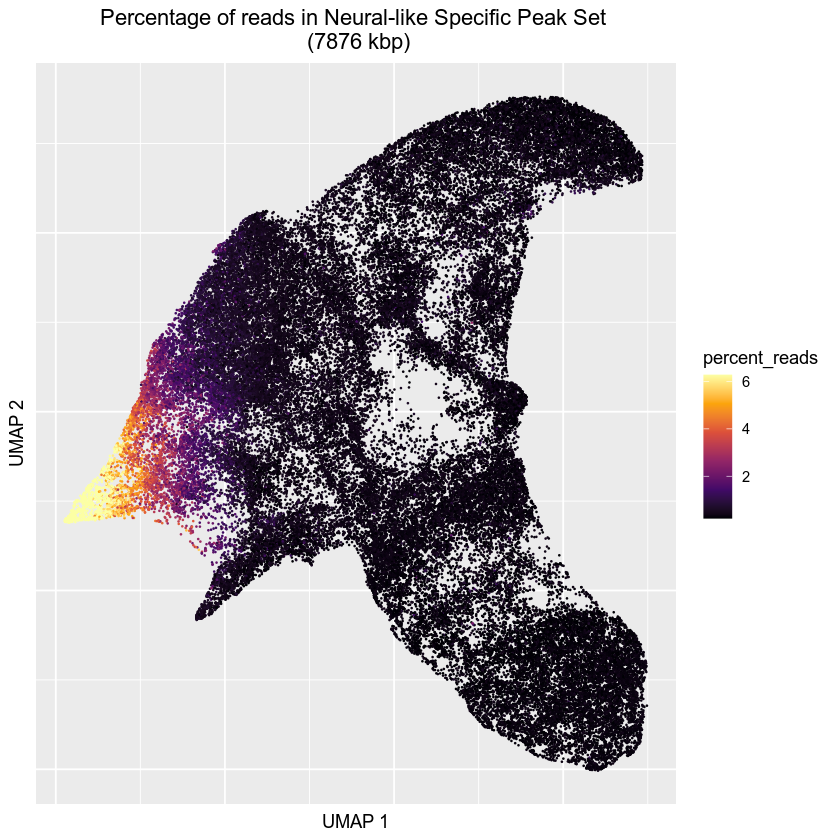

In [11]:
options(repr.plot.width = 7, repr.plot.height = 7)

df = data.frame(metaData, percent_reads=100*norm_reads_in_region)
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df) +
# ggplot(df[df$x.sp.sample %in% c("D14"), ]) +
geom_point(size=0.1, alpha=1, aes(x=umap1 , y=umap2, col=percent_reads)) +
ggtitle(sprintf("Percentage of reads in Neural-like Specific Peak Set \n (%d kbp)",  
               as.integer(sum(width(region_gr))/1000))) + 
xlab("UMAP 1") + ylab("UMAP 2") +
scale_color_viridis_c(limits=c(quantile(100*norm_reads_in_region, 0.1), 
                               quantile(100*norm_reads_in_region, 0.99)), 
                      oob=squish, option = "B") +
theme(plot.title = element_text(hjust = 0.5),
     axis.ticks = element_blank(),
     axis.text =element_blank())